**Cohort Analysis**

#Import

In [47]:
# import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

In [51]:
df = pd.read_csv('purchase.csv')

#Data Profiling and Preprocessing

In [52]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
3,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
4,2020-04-24 19:16:21 UTC,2294584263154074236,2273948316817424439,2.268105e+18,NaN,karcher,217.57,1.515916e+18


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633521 entries, 0 to 2633520
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   order_id       int64  
 2   product_id     int64  
 3   category_id    float64
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        float64
dtypes: float64(3), int64(2), object(3)
memory usage: 160.7+ MB


## Check and handling missing values

In [54]:
df.isna().sum()

event_time             0
order_id               0
product_id             0
category_id       431954
category_code     612202
brand             506005
price             431954
user_id          2069352
dtype: int64

The missing values in user id is very high and we need to check why the incident does happen. Deleting the missing values in user id or deleting the user id column is not an option because user id will become the important parameter in our analysis. Therefore, we will try the imputation method by assigning 0 or -999 so that the machine can recognize that the data is not real or is different.

In [55]:
df['user_id'] = df['user_id'].fillna(0)

In [57]:
df.isna().sum()

event_time            0
order_id              0
product_id            0
category_id      431954
category_code    612202
brand            506005
price            431954
user_id               0
dtype: int64

There are missing values in category id, category code, brand and price. Because the percentage of the missing value is not too high, We will try to drop the missing values in these columns

In [58]:
df = df.dropna(subset = ['category_id', 'category_code', 'brand', 'price'])
df.isna().sum()

event_time       0
order_id         0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
dtype: int64

##Check and handling duplicates

In [59]:
df.duplicated().sum()

500

Here, we know that there are few duplicate values in our data and we will try to delete those duplicates before further analysis is done

In [60]:
df = df.drop_duplicates()

In [61]:
df.duplicated().sum()

0

In [62]:
df.describe()

,order_id,product_id,category_id,price,user_id
count,1.531675e+06,1.531675e+06,1.531675e+06,1.531675e+06,1.531675e+06
mean,2.362467e+18,1.676933e+18,2.275819e+18,1.962131e+02,4.158944e+17
std,1.744931e+16,3.127787e+17,2.707903e+16,2.628926e+02,6.763823e+17
min,2.294360e+18,1.515966e+18,2.268105e+18,0.000000e+00,0.000000e+00
25%,2.348814e+18,1.515966e+18,2.268105e+18,2.914000e+01,0.000000e+00
50%,2.353263e+18,1.515966e+18,2.268105e+18,1.154900e+02,0.000000e+00
75%,2.383856e+18,1.515966e+18,2.268105e+18,2.546100e+02,1.515916e+18
max,2.388441e+18,2.388434e+18,2.374499e+18,5.092590e+04,1.515916e+18


Note that the minimum price of the purchase has to be more than zero (>0) and all of the columns must not have negative value

In [63]:
df=df[df['price'] > 0]
df.describe() 

,order_id,product_id,category_id,price,user_id
count,1.531650e+06,1.531650e+06,1.531650e+06,1.531650e+06,1.531650e+06
mean,2.362467e+18,1.676932e+18,2.275820e+18,1.962163e+02,4.158972e+17
std,1.744935e+16,3.127781e+17,2.707923e+16,2.628935e+02,6.763837e+17
min,2.294360e+18,1.515966e+18,2.268105e+18,2.000000e-02,0.000000e+00
25%,2.348814e+18,1.515966e+18,2.268105e+18,2.914000e+01,0.000000e+00
50%,2.353263e+18,1.515966e+18,2.268105e+18,1.154900e+02,0.000000e+00
75%,2.383856e+18,1.515966e+18,2.268105e+18,2.546100e+02,1.515916e+18
max,2.388441e+18,2.388434e+18,2.374499e+18,5.092590e+04,1.515916e+18


##Change data type

In [64]:
df = df.reset_index(drop = True)

In [65]:
df['event_time'] = pd.to_datetime(df['event_time'])

Here, we need to filter the purchase year on year 2020 so that the cohort table will not be too far in terms of the month range

In [66]:
df = df[df['event_time'].dt.year == 2020]

In [67]:
df.head()

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18
2,2020-04-26 08:45:57+00:00,2295716521449619559,1515966223509261697,2.268105e+18,furniture.kitchen.table,maestro,39.33,1.515916e+18
3,2020-04-26 09:33:47+00:00,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18
4,2020-04-26 14:55:26+00:00,2295902490203259134,2273948311742316796,2.268105e+18,appliances.kitchen.refrigerators,lg,462.94,1.515916e+18


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1521394 entries, 0 to 1531649
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   event_time     1521394 non-null  datetime64[ns, UTC]
 1   order_id       1521394 non-null  int64              
 2   product_id     1521394 non-null  int64              
 3   category_id    1521394 non-null  float64            
 4   category_code  1521394 non-null  object             
 5   brand          1521394 non-null  object             
 6   price          1521394 non-null  float64            
 7   user_id        1521394 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(2), object(2)
memory usage: 104.5+ MB


#Cohort Analysis

For cohort analysis, there are a some labels that we need to create which is:
- **Purchase period**: A string representation of the year and month of a single transaction/purchase
- **Cohort group**: A string representation of the the year and month of a user’s first purchase. This label is common across all purchases for a particular customer.
- **Cohort period / Cohort Index**: A integer representation a user’s stage in its “lifetime”. The number represents the number of months that have passed since the first purchase.


In [69]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['PurchaseMonth'] = df['event_time'].apply(get_month)
grouping = df.groupby('user_id')['PurchaseMonth']
df['CohortMonth'] = grouping.transform('min')
df

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,PurchaseMonth,CohortMonth
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,2020-04-01,2020-04-01
1,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,2020-04-01,2020-04-01
2,2020-04-26 08:45:57+00:00,2295716521449619559,1515966223509261697,2.268105e+18,furniture.kitchen.table,maestro,39.33,1.515916e+18,2020-04-01,2020-04-01
3,2020-04-26 09:33:47+00:00,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18,2020-04-01,2020-04-01
4,2020-04-26 14:55:26+00:00,2295902490203259134,2273948311742316796,2.268105e+18,appliances.kitchen.refrigerators,lg,462.94,1.515916e+18,2020-04-01,2020-04-01
...,...,...,...,...,...,...,...,...,...,...
1531645,2020-11-21 10:08:54+00:00,2388440981134693941,1515966223509088622,2.374499e+18,electronics.video.tv,lg,370.35,1.515916e+18,2020-11-01,2020-11-01
1531646,2020-11-21 10:10:01+00:00,2388440981134693942,1515966223526602848,2.268105e+18,electronics.smartphone,oppo,138.87,1.515916e+18,2020-11-01,2020-11-01
1531647,2020-11-21 10:10:13+00:00,2388440981134693943,1515966223509089282,2.268105e+18,electronics.smartphone,apple,418.96,1.515916e+18,2020-11-01,2020-11-01
1531648,2020-11-21 10:10:30+00:00,2388440981134693944,1515966223509089917,2.268105e+18,appliances.personal.scales,vitek,12.48,1.515916e+18,2020-11-01,2020-11-01


In [70]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

purchase_year,purchase_month,_ = get_month_int(df,'PurchaseMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = purchase_year - cohort_year 
month_diff = purchase_month - cohort_month 

df['CohortIndex'] = year_diff * 12 + month_diff

In [71]:
df

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id,PurchaseMonth,CohortMonth,CohortIndex
0,2020-04-24 11:50:39+00:00,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18,2020-04-01,2020-04-01,0
1,2020-04-24 14:37:43+00:00,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18,2020-04-01,2020-04-01,0
2,2020-04-26 08:45:57+00:00,2295716521449619559,1515966223509261697,2.268105e+18,furniture.kitchen.table,maestro,39.33,1.515916e+18,2020-04-01,2020-04-01,0
3,2020-04-26 09:33:47+00:00,2295740594749702229,1515966223509104892,2.268105e+18,electronics.smartphone,apple,1387.01,1.515916e+18,2020-04-01,2020-04-01,0
4,2020-04-26 14:55:26+00:00,2295902490203259134,2273948311742316796,2.268105e+18,appliances.kitchen.refrigerators,lg,462.94,1.515916e+18,2020-04-01,2020-04-01,0
...,...,...,...,...,...,...,...,...,...,...,...
1531645,2020-11-21 10:08:54+00:00,2388440981134693941,1515966223509088622,2.374499e+18,electronics.video.tv,lg,370.35,1.515916e+18,2020-11-01,2020-11-01,0
1531646,2020-11-21 10:10:01+00:00,2388440981134693942,1515966223526602848,2.268105e+18,electronics.smartphone,oppo,138.87,1.515916e+18,2020-11-01,2020-11-01,0
1531647,2020-11-21 10:10:13+00:00,2388440981134693943,1515966223509089282,2.268105e+18,electronics.smartphone,apple,418.96,1.515916e+18,2020-11-01,2020-11-01,0
1531648,2020-11-21 10:10:30+00:00,2388440981134693944,1515966223509089917,2.268105e+18,appliances.personal.scales,vitek,12.48,1.515916e+18,2020-11-01,2020-11-01,0


In [72]:
#Count monthly active customers from each cohort
df_temp = df.copy()
df_temp['CohortMonth'] = df_temp['CohortMonth'].apply(lambda row:row.strftime('%Y-%m'))
grouping = df_temp.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['user_id'].apply(pd.Series.nunique)

In [74]:
cohort_data

CohortMonth  CohortIndex
2020-01      0              1432
             1               463
             2               406
             3               350
             4               558
                            ... 
2020-09      1              1580
             2               675
2020-10      0              5771
             1               803
2020-11      0              2959
Name: user_id, Length: 66, dtype: int64

In [75]:
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='user_id')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10
CohortMonth,,,,,,,,,,,
2020-01,1432.0,463.0,406.0,350.0,558.0,557.0,505.0,555.0,497.0,309.0,224.0
2020-02,1390.0,394.0,290.0,502.0,510.0,489.0,503.0,433.0,266.0,211.0,NaN
2020-03,1393.0,314.0,548.0,519.0,459.0,510.0,448.0,270.0,176.0,NaN,NaN
2020-04,3775.0,856.0,576.0,790.0,795.0,589.0,383.0,205.0,NaN,NaN,NaN
2020-05,13047.0,1722.0,2169.0,2173.0,1438.0,858.0,457.0,NaN,NaN,NaN,NaN
2020-06,8426.0,1841.0,1588.0,1048.0,674.0,379.0,NaN,NaN,NaN,NaN,NaN
2020-07,21540.0,4739.0,2107.0,1280.0,628.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,22496.0,3098.0,1843.0,989.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,8552.0,1580.0,675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,0,1,2,3,4,5,6,7,8,9,10
CohortMonth,,,,,,,,,,,
2020-01,100.0,32.3,28.4,24.4,39.0,38.9,35.3,38.8,34.7,21.6,15.6
2020-02,100.0,28.3,20.9,36.1,36.7,35.2,36.2,31.2,19.1,15.2,NaN
2020-03,100.0,22.5,39.3,37.3,33.0,36.6,32.2,19.4,12.6,NaN,NaN
2020-04,100.0,22.7,15.3,20.9,21.1,15.6,10.1,5.4,NaN,NaN,NaN
2020-05,100.0,13.2,16.6,16.7,11.0,6.6,3.5,NaN,NaN,NaN,NaN
2020-06,100.0,21.8,18.8,12.4,8.0,4.5,NaN,NaN,NaN,NaN,NaN
2020-07,100.0,22.0,9.8,5.9,2.9,NaN,NaN,NaN,NaN,NaN,NaN
2020-08,100.0,13.8,8.2,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09,100.0,18.5,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


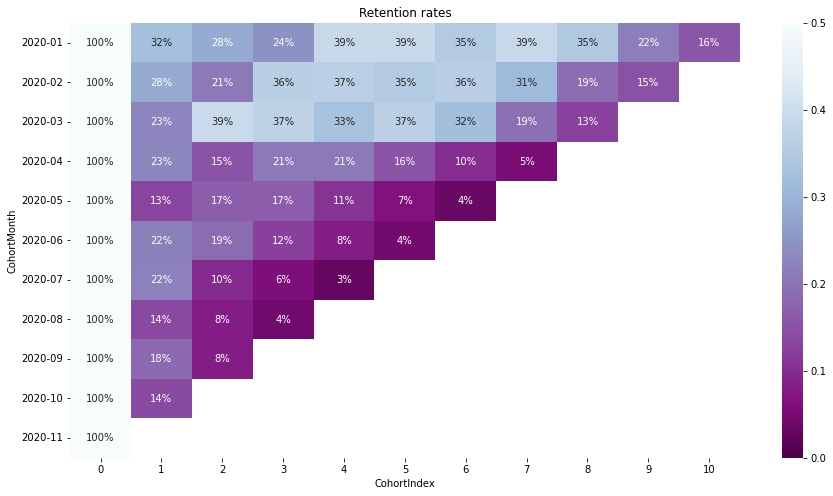

In [77]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

From the perspective of retention over product lifetime from the graph above, we can see that **the active users until current month is about 14% of total users**. There is significant drop in product retention rate from **April to May** and from **July to August**. The retention rate over product lifetime fluctuates from month to month but tends to drop as the time goes on. This indicates that the product performance has to be reevaluated and reviewed to increase retention rate. Meanwhile, we can also see that the users who joined in the early year tend to have higher product retention rate than those who joined in mid-year and late year. From the perspective of retention over user lifetime, the drop in retention rate is significant from **September to October**. This indicates that the customer support or the operations has to reevaluated and reviewed on that time range to maintain the user retention rate

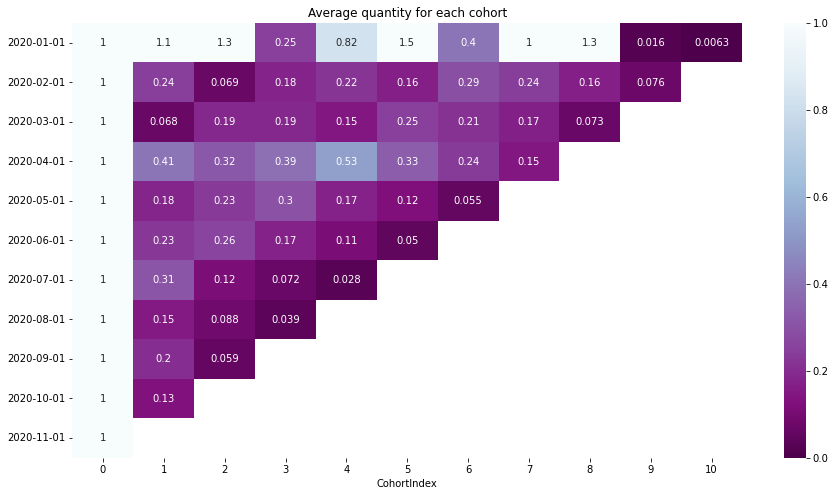

In [79]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['price'].sum()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='price')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

# Retention table
cohort_size = average_quantity.iloc[:,0]
retention = average_quantity.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=retention,annot = True,vmin = 0.0,vmax =1,cmap="BuPu_r")
plt.show()

From the graph above, we can see that the users who joined in the early year tends to have higher spending throughout the year. It is also noted that the increase in user's spending rise from June to July. This may happen because of successful campaign, good operations or good customer support, etc. In the other hand, the user's spending meets its highest drop from **September to October**. From the previous graph, the user retention rate also drops significantly in this timeframe. This incident must have something to do with customer support or operations and have to be reevaluated.